次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業の潜在価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [530]:
using StatsPlots
using Random
using Statistics

In [531]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.02, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.98*firms[i].hiddenCorporateValue + 0.02*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    lst = []
    marketCap, mean_ln_amp, fundamentals_sum = 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_ln_amp += log(marketCap/fundamentals)
        fundamentals_sum += fundamentals
    end
    mean_ln_amp /= size(firms)[1]
    sort!(lst)
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = min(firms[i].stockPrice, (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity))
            push!(sell, (i, p, q))
        end
    end
    #   仮買い。
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        p = (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell, rev=true)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if agent.money - going_to_buy_price < 0.5*agent.portfolio_target[1]
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price <= 0.0 || quantity == 0.0
            continue
        end
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        if rand() < 0.01 - 0.01*(agent.total_assets_log[end] - agent.total_assets_log[end-9])/agent.total_assets_log[end-9]
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/std(agent.params[3:7])
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    Π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * Π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end

run_one_term (generic function with 1 method)

In [532]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0
agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        init_stock_price*init_stock_quantity,
        [],
        [],
    ) for _ = 1:M
];

In [533]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [534]:
T = 10^3
income_lst = [0.0002*init_money*2^(0.01*t) for t = 1:T] 
#   income=constantだと、金融市場の規模が継続的に大きく（小さく）ならないためか、
#   適応の結果ポートフォリオ配分目標に占める預金の割合がとても大きくなる。そして売買が減り、値動きが激減する
@time for t = 1:T
    income = income_lst[t]
    run_one_term(agents, firms, income)
end

 11.742258 seconds (82.94 M allocations: 1.842 GiB, 4.39% gc time, 7.65% compilation time)


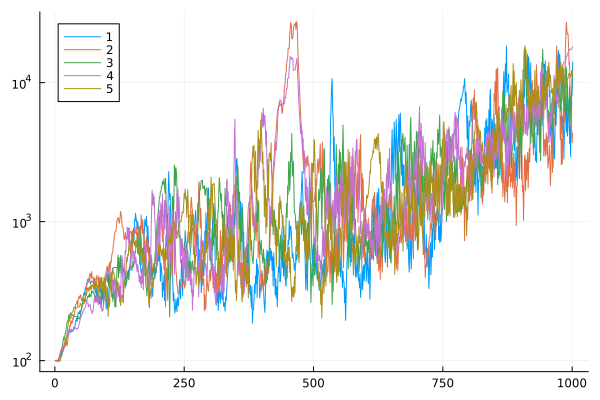

In [535]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

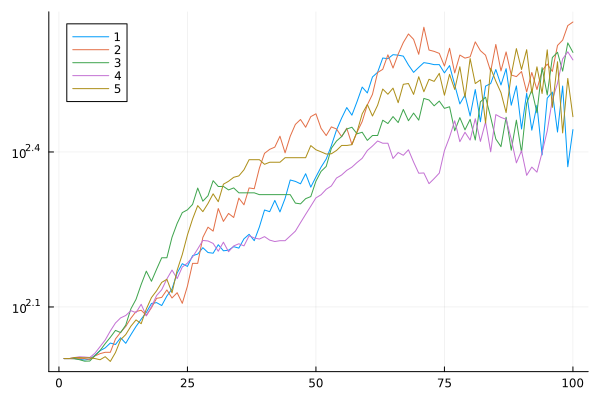

In [536]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

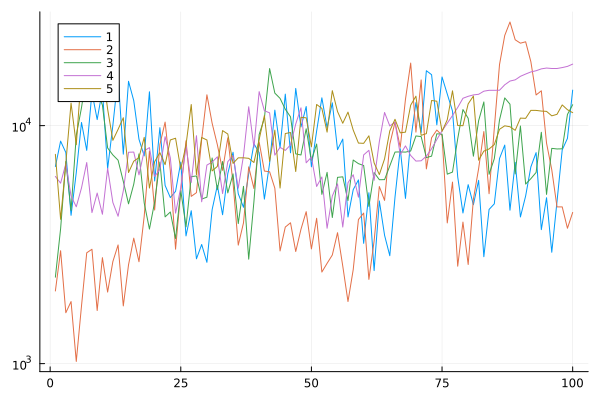

In [537]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log10)

In [538]:
for i = 1:10
    println(i, agents[i].portfolio_target)
end

1[3376.4593918526416, 1540.9006836367125]
2[2026.457891035956, 358.5428766659834]
3[2977.6277417637325, 868.2920980194274]
4[2014.4925524285384, 3046.142796441508]
5[2341.6388586296725, 308.9832366718409]
6[2792.455167506885, 493.5568671519751]
7[2571.7569056840894, 914.6179326820559]
8[2160.9397912824184, 236.79940565773813]
9[3193.4984297021556, 813.2823679513509]
10[2025.2788756818898, 290.7090846766903]


In [539]:
agents

100-element Vector{Agent}:
 Agent("fundamentals", 2473.417416032212, [0.5380125491821731, 0.0, 0.0, 8.042409998432731, 0.9791805451900839, 1.5716723365853078, 1.9029010062695553, 1.3604833751938992, 1.1435935374368966, 0.0], [75.84346274975553, 0.0, 0.0, 1458.083943713249, 110.97557874395751, 248.21084078331558, 134.82811215712945, 180.67919683973182, 253.7535244700023, 0.0], [100.0, 100.69588154348084, 101.41315127058073, 102.1165263073705, 102.808581241109, 103.51317366537432, 104.30402681496749, 105.08061102582914, 105.1366796831775, 105.27276636086664  …  4287.745945158609, 4380.100955035408, 4484.63016015852, 4650.3805267553, 4558.468455299513, 4597.25012992762, 4801.61125878402, 4729.165521305802, 4947.179099969602, 4917.360075489354], [0.686640664913405, 13.0], [22.279226309174657, 17.851189220159846, 57.025427195897166, 136.13773929367002, 62.71245185599497, 188.38888706430347, 95.38321798528328, 103.84529966667169, 119.04427299046607, 35.77876200091003], [3376.4593918526416, 1

In [540]:
firms

10-element Vector{Firm}:
 Firm(140.96969088368726, 100.0, [1.0, 1.0, 1.0, 0.9969385468648913, 0.9936278449638691, 0.9981391935531236, 1.0144388409150533, 1.0357893901714328, 1.0489441967196511, 1.071728009264039  …  50.64553396628875, 67.08465511407299, 77.01556836215484, 36.55017094246357, 49.773145077479036, 29.36547864071357, 47.96006521014721, 79.08345823075348, 88.37603692168292, 140.96969088368726], [100.0], 14096.969088368727, 22.044259957760712, Any[(77.56359159047366, 0.004307464545863223, 60), (77.59798160182645, 0.06521641859943542, 98), (77.59840114223088, 0.017670449465153282, 79), (77.61163181383851, 0.009884349949648862, 55), (77.69218546989836, 0.3844164793390341, 46), (156.26389975155672, 0.9307975117627564, 76), (158.06204967104316, 1.2532319744785314, 97), (161.93405030263904, 0.37545107705006603, 25), (191.29188616265776, 0.4372595165880526, 90), (191.70460342192777, 0.37421986178246275, 36), (195.30685745412507, 0.6552467441289134, 71), (200.79000424940358, 1.09863

In [541]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

280004.07980603

In [542]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

22.044259957760712
18.1332068460247
56.48631182687185
136.9993417033668
63.11463906884063
186.98799332948946
95.36609411200467
103.83040542216877
117.39977501954705
35.419546900086644


In [543]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

14096.969088368727
4316.526361096418
12240.15852951062
18129.93796632345
11333.515487934284
15792.785493863854
7085.398121757595
13280.514862151918
22189.135926627638
2644.986528328072


In [544]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[22.279226309174657, 17.851189220159846, 57.025427195897166, 136.13773929367002, 62.71245185599497, 188.38888706430347, 95.38321798528328, 103.84529966667169, 119.04427299046607, 35.77876200091003]
[22.199729903941538, 17.866856587360797, 55.25885538428824, 138.5554208882433, 64.18703808814429, 189.21884045759464, 95.52145203941633, 105.6141965337954, 119.30463934637442, 34.886634717075644]
[22.52588355398114, 18.092609275354416, 56.277417755734675, 139.33325974497524, 62.5056941741677, 186.5920000648237, 95.8100297734122, 103.90374329365464, 116.3912945194859, 35.37231574072991]
[21.77318544219768, 17.630262972952348, 57.3153646612194, 137.28006546357588, 62.62524646172615, 187.69969665609614, 95.33170922664381, 104.62986748020602, 118.38816109927822, 35.79312716867525]
[21.88760988213555, 17.85451153019282, 55.32467981456763, 140.09656755820177, 62.80471420755473, 183.3601676698557, 95.01567042678451, 104.32266665291652, 117.88687304713608, 35.253386615958156]
[22.53132736598489, 17.

In [545]:
for agent in agents[1:10]
    println(agent.params)
end

[0.686640664913405, 13.0]
[0.8496676053436006, 43.0]
[0.774230318313555, 1.0]
[0.39807107478675385, 4.0, -1.1469814228694744, 0.781492626005793, 0.9317426933654683, -1.0060504251138394, 0.4397965286120524, -0.18611489076122864, 0.22727377400056958, 0.5020814763347521, 0.8422559979147449, 13.0]
[0.8834299173693814, 2.0, 0.8735792216826167, -1.0320534970884745, -1.0258391880169095, 1.0493654876962377, 0.1349479757265298, -0.24070985405084522, 0.3751018471865686, 0.6289581300342119, 0.7382790563038527, 23.0]
[0.8498006513834286, 1.0, -1.1097034734001354, 1.0365876875571278, -0.6878682992666587, 1.062889646997264, -0.3019055618875975, 0.4495881281512544, -0.6596634221119305, 0.012253488776368034, 0.6215634436179861, 21.0]
[0.7376593237717713, 1.0, -1.067618385742141, 0.8873729015799156, -0.8465312768009098, 1.1572089513465542, -0.13043219038341874, -0.1994288876119582, -1.0704223871835203, -0.4054078913643083, 0.38372949381840515, 5.0]
[0.9012405494476102, 4.0, -1.1730362542992974, 0.79767

In [546]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.5380125491821731, 0.0, 0.0, 8.042409998432731, 0.9791805451900839, 1.5716723365853078, 1.9029010062695553, 1.3604833751938992, 1.1435935374368966, 0.0]
[0.0, 0.2135387002532593, 0.0, 0.0, 0.0, 0.0, 0.554965571988336, 0.0, 0.35286165107874634, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.019703430700807, 0.0, 0.0, 0.0]
[3.0310944956674613, 2.240273184813881, 4.555699908517074, 0.0, 0.0, 0.0, 2.240686409846162, 1.099272218403314, 4.619328417162147, 0.0]
[1.8733342451828494, 0.0, 0.584400332281577, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23339001590783176, 0.0]
[2.6045925660489115, 1.787218916437476, 0.0, 0.6447507238737413, 3.0794894324517053, 0.6243601789102537, 2.5143572653707515, 5.022727713721143, 0.0, 0.7308108498626974]
[8.3231812696225, 0.0, 3.581093228743184, 0.0, 0.0, 0.0, 0.0, 1.883461660677092, 1.5387893566675106, 0.0]
[0.8747107105625901, 0.0, 1.5328791632055654, 0.0, 0.0, 0.0, 1.9410923093177375, 0.0, 0.7839182485335955, 0.0]
[0.27485800884650247, 0.0, 0.5063750931440913, 0.7100652333641229,

In [547]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
